# 2-Point Statistics Example: Steel Microstructure

This page is an example of how to obtain 2-point statistics using PyMKS tools. The workflow is the following: import image dataset from PyMKS database, display the images in the dataset, threshold the images if necessary, and calculate 2-point statistics for the images.

First, we will go through the process of calculating 2-point statistics on the full-size images at different magnifications and then perform the same procedure on cropped versions of the original images. Since sometimes images are very large, and we want to crop them to reduce the effort of computing the 2-point statistics. 

The dataset that we are importing is optical micrographs of chemically etched low carbon steel. It is etched to display some features of the microstructure, which otherwise would not be visible.

First we are going to import the image dataset from the PyMKS database.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pymks_share import DataManager
manager = DataManager ('pymks.me.gatech.edu')
X = manager.fetch_data('Low-Carbon Steel Optical Micrographs')
meta= manager.fetch_metadata('Low-Carbon Steel Optical Micrographs')
meta

{u'_id': ObjectId('56b230901564382850c718b0'),
 u'authors': u'Almambet Iskakov',
 u'data_source': u'Optical images of etched low carbon steel rod at four magnification levels',
 u'dataset_name': u'Low-Carbon Steel Optical Micrographs',
 u'description': u'Commercially available steel (McMaster)Etched with 2% Nital sol',
 u'other_metadata': u'None',
 u'parameters': {u'Exposure': u'Samples not exposed to service'}}

Note that we chose to display the metadata of the image dataset by using the 'meta' command above.

Now, we will display the images using the PyMKS 'draw_microstructure' tool.

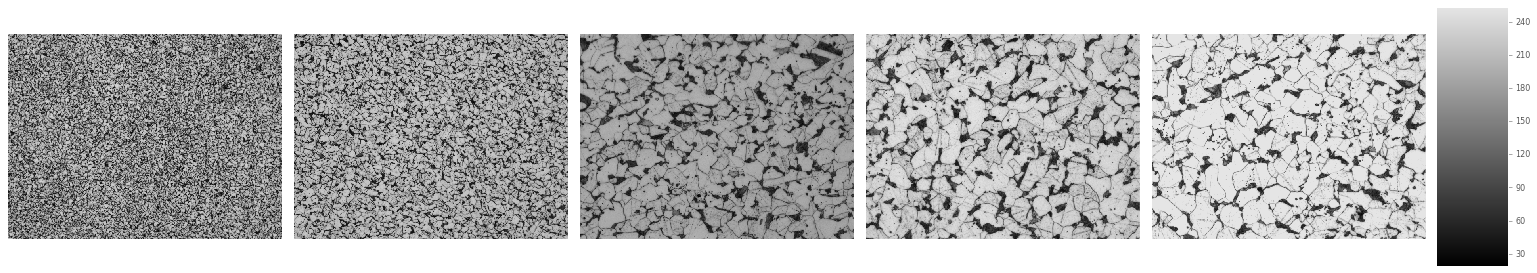

In [3]:
import skimage.io as io
import matplotlib.pylab as plt
import numpy as np
from pymks.tools import draw_microstructures

draw_microstructures(X)

The images were taken at different magnifications (increasing left to right), 50x, 100x, 200x, 500x, and 500x with higher exposure value. Although the images were obtained using the same equipment, there are some variations in brightness, contrast, exposure, etc., to account for variation in image collection process.

The imported images are in grayscale. We need to make them black and white, since we know that there are only two different particles in the microstructure. We do this by thresholding the image using Otsu's method. By thresholding, each pixel in the image will become either black or white, giving us only 2 local states.

In [4]:
from skimage.filters import threshold_otsu

samples = len(X)
X_binary = np.ndarray(shape=(samples,X.shape[1],X.shape[2]))
X_binary.shape
i=0
for x in X:
    x_thresh = threshold_otsu(x)
    X_binary[i] = x > x_thresh
    i += 1

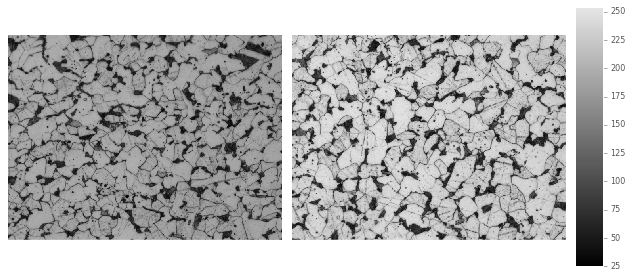

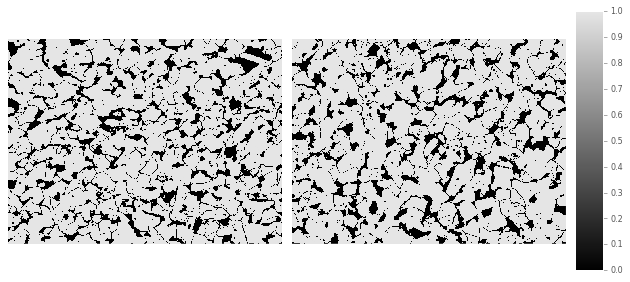

In [7]:
draw_microstructures(X[2:4,:,:])
draw_microstructures(X_binary[2:4,:,:])

We plotted two original images at 200x (top left) and 500x (top right) to compare with their thresholded image (bottom). The original images have 256 shades of gray and the thresholded images have only two shades, 0 or 1, seen in the scale bar.

In the original images, we can clearly see grain boundaries, whereas in the thresholded images, some of the grain boundaries are removed from the image, better seen in the 500x image (bottom right).

Now we are going to compute correlations using PyMKS 'correlate' tool, which computes auto- and cross-correlations for all phases in the microstructure. We have 2 phases in our microstructure ('n_states=2').

In [8]:
from pymks.stats import correlate
from pymks import PrimitiveBasis

prim_basis = PrimitiveBasis(n_states=2)
X_ = prim_basis.discretize(X_binary)
X_corr = correlate(X_, periodic_axes=(0,1))
print "Shape of X_corr", X_corr.shape

Shape of X_corr (5L, 520L, 694L, 3L)


After computing the correlations we have three correlation results for each of our 5 microstructures. Note that the array of each correlation plot is the same as the original image. For each image we obtain 3 correlation plots.

We will plot the 2-point statistics below. 

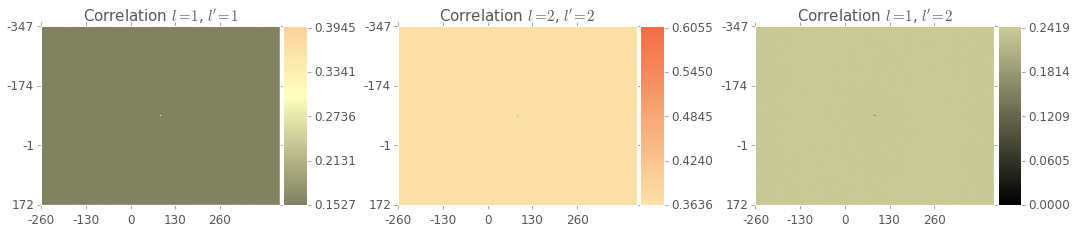

Volume fraction of black phase 0.394543879546
Volume fraction of white phase 0.605456087097


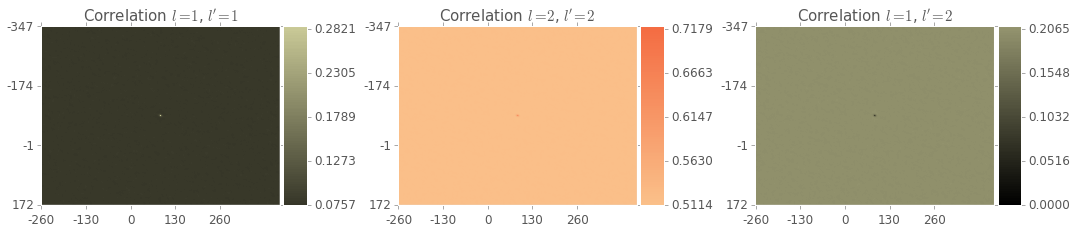

Volume fraction of black phase 0.282115929406
Volume fraction of white phase 0.717884037238


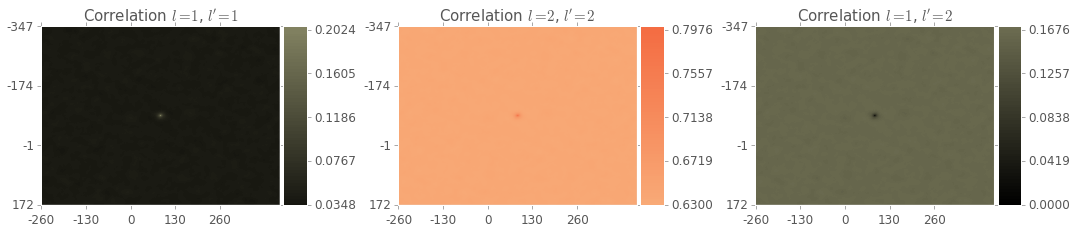

Volume fraction of black phase 0.202374743859
Volume fraction of white phase 0.797625222784


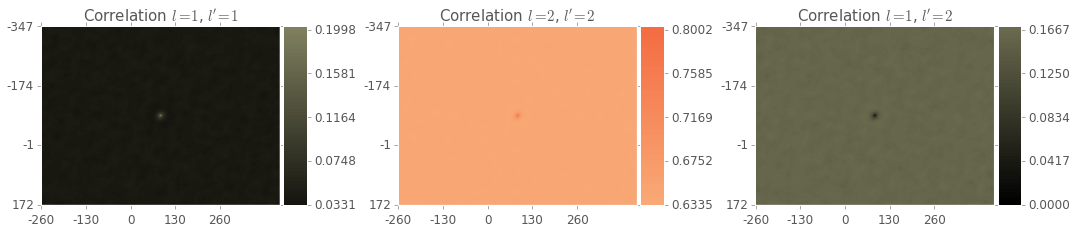

Volume fraction of black phase 0.199789397016
Volume fraction of white phase 0.800210569628


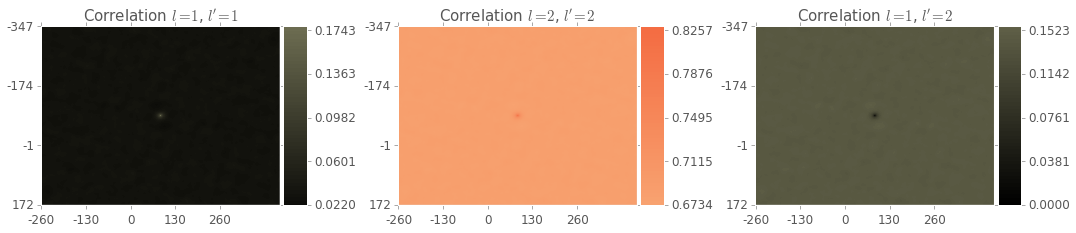

Volume fraction of black phase 0.174321098153
Volume fraction of white phase 0.82567886849


In [9]:
from pymks.tools import draw_correlations

for i in range(samples):
    draw_correlations(X_corr[i], correlations=[(1, 1), (2, 2), (1, 2)])
    x_center = (X_corr.shape[1] + 1) / 2
    y_center = (X_corr.shape[2] + 1) / 2
    print 'Volume fraction of black phase', X_corr[i, x_center, y_center, 0]
    print 'Volume fraction of white phase', X_corr[i, x_center, y_center, 1]

The above plots indicate the states on which the 2-point statistics have been calculated (black-black, white-white, black-white). In this case, the black phase is labelled as 1 and white phase as 2. The grain pattern in the original images seem random and the grain shapes are different. From the correlation plots, we cannot tell any microstructure features or patterns that clearly stand out. 

We can focus on the volume fractions for each image. For images at highest magnification (500x) the volume fraction of the black phase is minimum at 17.4%, and at lowest magnification (50x), it is 39.5%. 

The difference in volume fraction is because the lower magnification images retained a higher amount of grain boundary information in the image after thresholding. Grain boundary information is not desirable since it is not part of a particular phase. A grain boundary can separate two phases that appear white, and the statistics treat the grain boundary as a black phase, which will not be accurate.

Since we see less grain boundaries in the higher magnification images (500x), these images are more reliable for computing 2-point statistics. The images with 500x show a volume fraction of black phase of 20.0% and 17.4%. The image of 200x shows a volume fraction of 20.2%, which is in good agreement with the statistics of 500x images compared to 50x and 100x, 39.5% and 28.2%, respectively. 

The volume fractions vary slightly in 200x and 500x images, which is expected since the images were taken at different locations. However, the etched images at higher magnification are more reliable for 2-statistics since they do include as much grain boundary information as the lower magnification images.

# 2-Point Statistics on Cropped Images
Now we are going to crop the image to the first 300 pixels in horizontal and vertical directions and repeat the process of computing the 2-point statistics. Our new images are going to be 300x300 pixels.

Shape of X (5L, 200L, 200L)


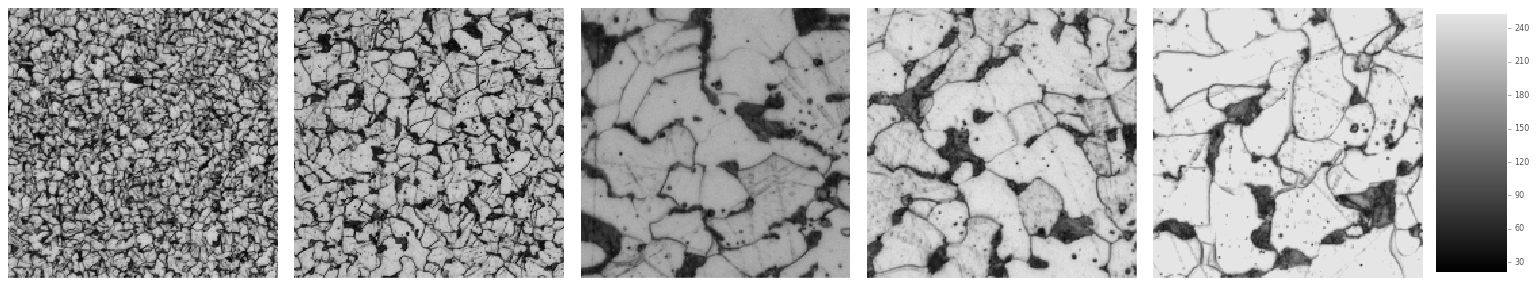

In [19]:
X = X[:,0:250,0:250]
print 'Shape of X', X.shape
draw_microstructures(X)

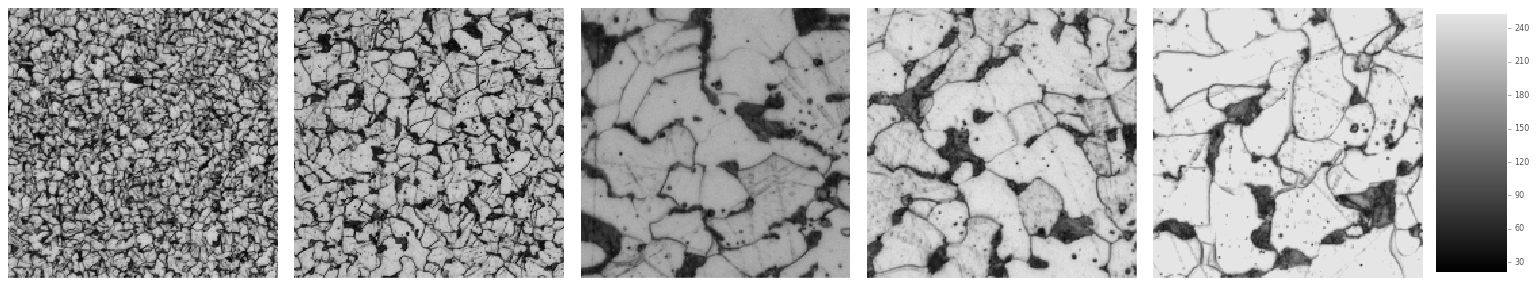

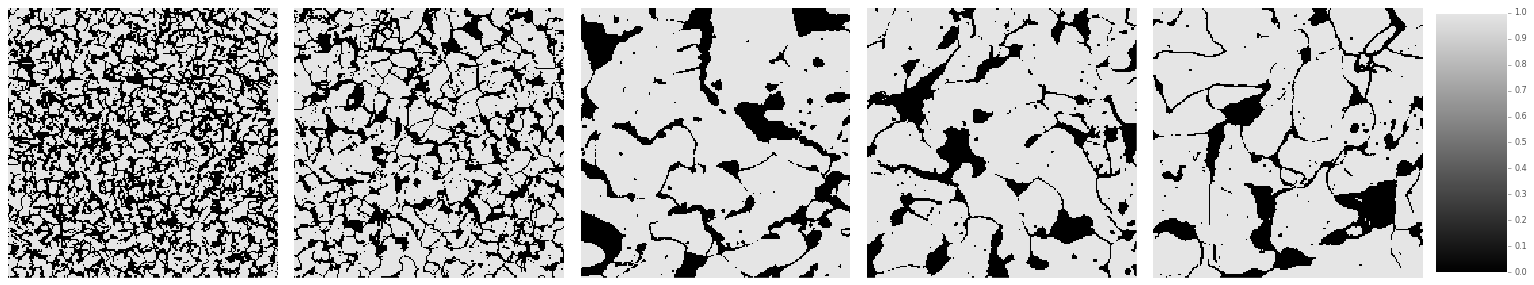

In [20]:
samples = len(X)
X_binary = np.ndarray(shape=(samples,X.shape[1],X.shape[2]))
X_binary.shape
i=0
for x in X:
    x_thresh = threshold_otsu(x)
    X_binary[i] = x > x_thresh
    i += 1
    
draw_microstructures(X)
draw_microstructures(X_binary)

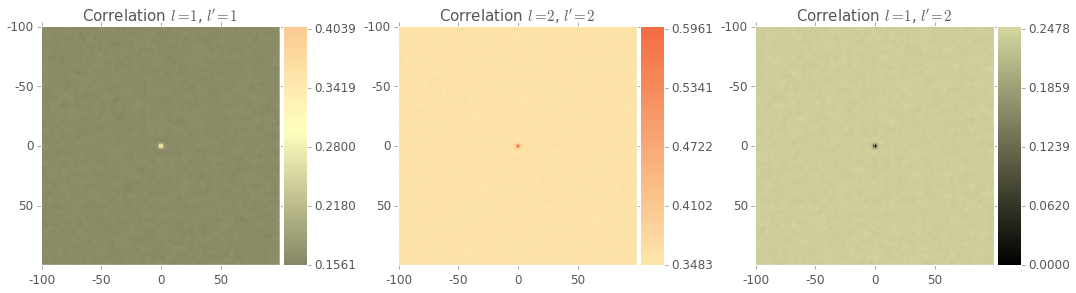

Volume fraction of black phase 0.403899989797
Volume fraction of white phase 0.596099984941


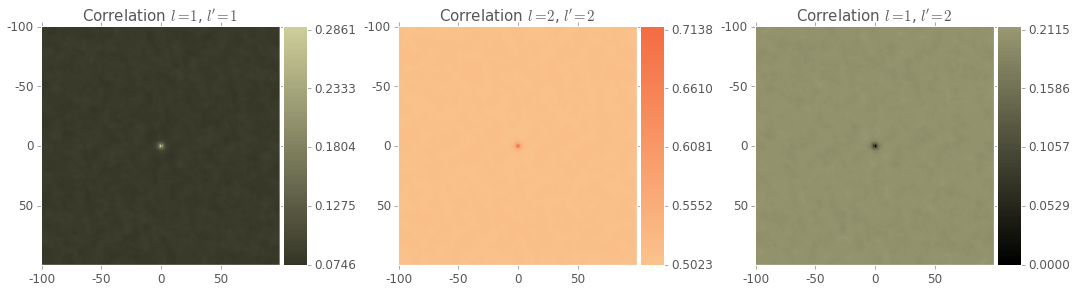

Volume fraction of black phase 0.286149992771
Volume fraction of white phase 0.713849981967


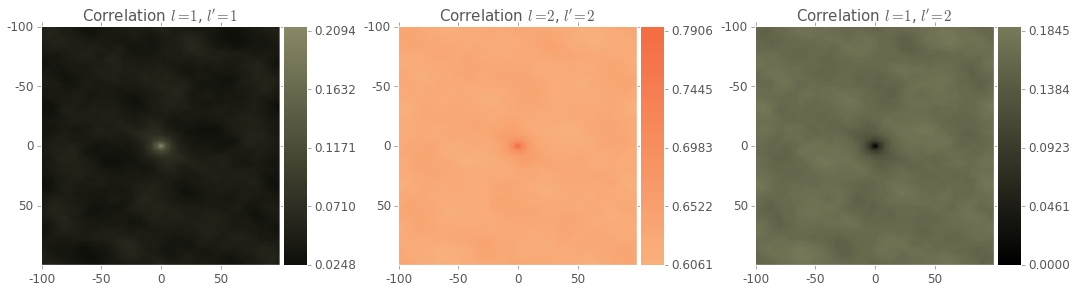

Volume fraction of black phase 0.209374994711
Volume fraction of white phase 0.790624980027


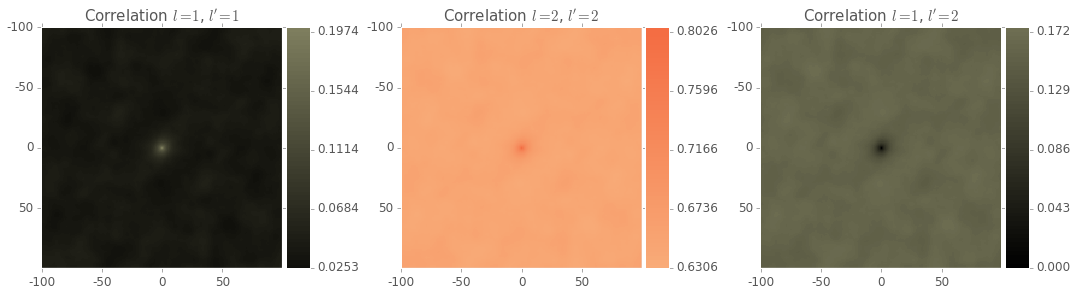

Volume fraction of black phase 0.197374995014
Volume fraction of white phase 0.802624979724


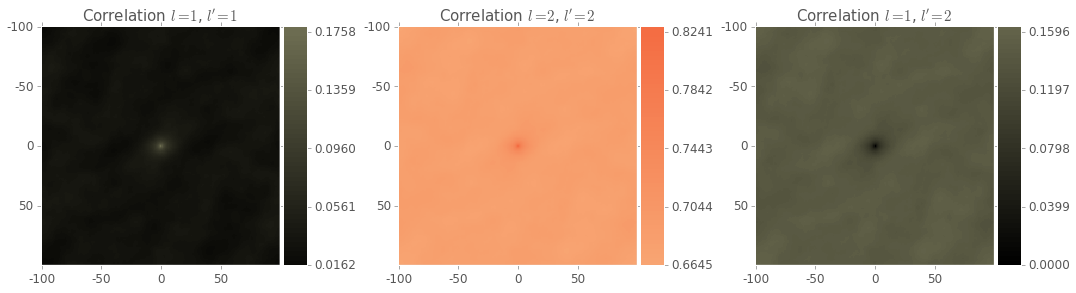

Volume fraction of black phase 0.175849995558
Volume fraction of white phase 0.82414997918


In [21]:
prim_basis = PrimitiveBasis(n_states=2)
X_ = prim_basis.discretize(X_binary)
X_corr = correlate(X_, periodic_axes=(0,1))

for i in range(samples):
    draw_correlations(X_corr[i], correlations=[(1, 1), (2, 2), (1, 2)])
    x_center = (X_corr.shape[1] + 1) / 2
    y_center = (X_corr.shape[2] + 1) / 2
    print 'Volume fraction of black phase', X_corr[i, x_center, y_center, 0]
    print 'Volume fraction of white phase', X_corr[i, x_center, y_center, 1]

We have computed the 2-point statistics for the cropped images. The volume fractions for cropped images are very close to the volume fractions of the original resolution images, within 5% difference.

At higher resolution images (500x) we can now better observe the distribution of the black and white phases. For example, in 2-point statistics result for last image, we can see the distribution of the black and white phases in a diagonal direction. It is not so evident for lower magnification images.

We now have more meaningful 2-point statistics plots for the cropped images at higher magnifications (200x, 500x). However, for lower magnification images we do not yet have insightful spatial correlations. To improve the spatial statistics for 50x and 100x, we can crop the images further, which will approximately match the view field of the higher magnification images.

Spatial correlations are a more rigorous way to analyze microstructure images rather than using intuition and expertise. It is important to have an image with a view field that is representative of the whole microstructure for 2-point statistics computations. Once two point statistics have been computed for a dataset, the spatial correlations can by further analyzed using principal component analysis (PCA).